# Generatív modellek és a GAN

A generatív modellek alatt olyan gépi-tanulásos architektúrákat értünk, amelyek célja, hogy új adatot állítson elő. A létrejött adatnak hasonlítnia kell a tanítómintához, vagyis a generált minták eloszlásának közelítenie kell a valós adatok eloszlását. Az ilyen modelleknek meg kell tanulnia a tanítóminta jellegzetességeit és azt is, hogy ezen jellegeket a belső reprezentációjából hogyan tudná értelmezhető formában előállítani. A generatív modellek esetében ha a modell a tanítóminta képeit generálná csupán vissza pixel-pontosan, úgy a modell elveszti célját és egyfajta ovefitting-nek tekinthetnénk a jelenséget.

Egyes szerzők a minél valóságűbb eredményekre törekedtek, ehhez vagy Variational Autoencoder alapú architektúrát használtak (Ramesh et al., 2021), vagy a Generative Adverserial Network alapokon nyugvó megoldásokat (Dong et al., 2021; Reed et al., 2016; Xu et al., 2018; Zhang et al., 2018).

Az Autoencoder egy olyan statisztikai elveken alapuló architektúra, amelynek célja, hogy a tanítóhalmaz jellegzetességeit feltérképezze és olyan formába kódolja a tulajdonságokat, hogy azokból az eredeti adat visszaállítható legyen. Az architektúra lényegében egy nehezen kezelhető sűrűségfüggvényt definiál, egy látens taggal, így ebben az esetben nem lehet közvetlenül optimalizálni, nem úgy mint például a pixelRNN/pixelCNN generatív modellek esetében (Oord et al., 2016), hanem az úgynevezett evidence lower bound (ELBO) mértékegységre kell optimalizálni. (Oord et al., 2017) Az architektúra két komponense az Encoder, amely előállítja a jellegvektorokat a bemenet alapján és a Decoder, amely a jellegvektorokból visszaállítja az adatot. Tehát ebben az esetben a cél az, hogy egy olyan reprezentációt készítsünk a tanítómintáról, amely alapján az teljes mértékben visszaállítható legyen. Egyfajta tömörítési folyamatnak is felfogható az encoder működése. Egy módosított változattal az encoder által létrehozandó látens tér olyan formában áll elő, amelyből véletlenszerűen is vehetünk mintákat és dekódolva teljesen új adat áll elő. Ezt a módszert Vector Quantised-Variational AutoEncoder-nek nevezték el, amely alkalmazható generatív modellként (Oord et al., 2017).
Ha az autoencoder-t képek generálására kívánjuk felhasználni, úgy a helyreállított képeken egyfajta homályosságot figyelhetünk meg, amely a dekódolás során jelentkező információvesztésből adódik.

A _Generative Adverserial Network_ (GAN), egy olyan generatív modell, amely nem a megszokott statisztikai alapokon optimalizál, mint például az Autoencoder vagy pixelRNN modellek, hanem játékelméleti megközelítést alkalmaz, így a modell tanítása is merőben másképp zajlik.
A tanulás során két neurális hálózat versenyzik egymással: egy _generátor_, amelynek az a szerepe, hogy a tanítómintákhoz hasonló adatot generáljon a bemeneti zajból és egy _diszkriminátor_, amely egy bináris osztályozó, amely a generátor által generált adatot vizsgálja és eldönti, hogy az valódi vagy hamis.
A tanítás során ezen két háló versenyzik egymással, együtt fejlődve. Az autoencoderhez képest a GAN-al generált képeken már nem figyelhető meg a homályosság, élesebb és fotorealisztikusabb képek generálása a fejlettebb GAN architektúrákkal megoldható.

A generátor bemenete egy zajvektor, amely általában Gauss- vagy egyenletes eloszlásból állítunk elő. Ezt a zajvektort az irodalom látens térnek is nevezi, hiszen a tanítás során a modell megtanulja, hogy ezen többdimenziós tér egyes pontjaira milyen kimenetet generáljon. Vagyis ezzel lényegében kitölti a rendelkezésre álló tér tartományait a megtanult jellegzetességekkel. A betanított generátorral, optimális esetben, ezen tér bármely pontját mintavételezve a tanítóhalmazhoz hasonló adatokat generálhatunk.

<img src="images/AEvsGAN.png" width="70%">

## GAN modell tanítása
Ha a legegyszerűbb esetet vizsgáljuk és csak a képek rendezetlen halmazára tanítjuk a modellt, mindenféle kiegészítő információ és annotáció nélkül, akkor a tanítás a következőképpen zajlik.
A továbbiakban a következő jelöléseket használom: legyen $D$ a _diszkriminátor_, $G$ pedig a _generátor_.

### Hibafüggvények
A $G$ és $D$ hibájának számolása a bináris kereszt-entrópián alapszik.
A bináris kereszt-entrópia hibafüggvény a következőképpen írható fel:
$$L(\hat y, y) = y . \log \hat y + (1-y). \log (1 - \hat y)$$
Ahol $\hat y$ a predikció, $y$ pedig a valós címke

In [1]:
from tensorflow.keras.losses import BinaryCrossentropy

cross_entropy = BinaryCrossentropy(from_logits=True)

2022-03-13 14:31:35.372298: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-03-13 14:31:35.372341: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


A Kerasban található implementáció egy segédfüggvényt ad vissza, amelyet különféle paraméterekkel inicializálhatunk. A `from_logits=True` paraméter esetén a keresztentrópia számolásnál nem szükséges a diszkriminátormodellnek tartalmaznia az utolsó sigmoid aktivációsfüggvényét, így úgynevezett Logits kimenettel fog rendelkezni. A számolás során a kimeneti értékekre alkalmazódik ebben az esetben a sigmoid függvény egy fajtája. A gradiensek számolása így egyszerűbb lesz a modell számára a backpropagation során (Tényleg?)

#### Diszkriminátor hibafüggvénye

A $G$ generátor egy $z \in \mathbb{R}^n, n \geq 1$ bemeneti zajvektor alapján előállít egy generált adatot $G(z)$.
A $D$ diszkriminátor egy bináris osztályozó, amelynek feladata, hogy az $x$ és $G(z)$ bemeneteit osztályozza.

$D(x)$ esetén 1, $D(G(z))$ esetén pedig 0 címkét várunk.

A hibafüggvény számolása két lépésben történik a kétféle bemenet miatt:

$D(x)$-re nézve a kereszt-entrópia a következő:
$$L(D(x), 1) = 1.\ln D(x) + (1 - 1).\ln(1 - D(x))$$
$$L(D(x), 1) = \ln D(x)$$
Vagyis jelen esetben $D$-nek a $\ln(D(x))$-et kell maximalizálnia.

$D(G(z))$-re nézve a kereszt-entrópia a következő:
$$L(D(G(z)), 0) = 0.\ln D(G(z)) + (1 - 0).\ln(1 - D(G(z)))$$
$$L(D(G(z)), 0) = \ln(1- D(G(z)))$$
Vagyis a $\ln(1 - D(G(z)))$-t kell maximalizálnia.

Egyetlen mintára a hibafüggvény a következőképpen néz ki:
$$\max V(D) = \ln D(x) + \ln(1 - D(G(z))$$

Batch-ra nézve:
$$\max V(D) = \mathbb{E}_{x \sim P(x)} \left[\ln D(x) \right] + \mathbb{E}_{z \sim P(z)} \left[\ln(1 - D(G(z))) \right]$$

Ahol a $P(x)$ a valószínűségi eloszlása a tanítóhalmaznak, $P(z)$ a valószínűségi eloszlása a $z$ zajvektornak. (látens tér).

In [2]:
def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    
    total_loss = real_loss + fake_loss
    return total_loss

#### Generátor hibafüggvénye

A $G$ generátor feladata az, hogy megtévessze a $D$ diszkriminátort azáltal, hogy a tanítóhalmazhoz hasonló adatokat generáljon.
Vagyis a $G$ érdeke az, hogy a $D(G(z))$ 1-es címkét kapjon 0 helyett.

Tehát a bináris keresztentrópia egy mintára:
$$L(D(G(z)), 0) = \ln(1 - D(G(z))$$
$D$ minimalizálni kívánja a $D(G(z))$-t, míg a $G$ maximalizálni szándékozik azt.

A $G$ a tanítás során sosem fog valódi adatot látni, de a teljesség kedvééert a hibafüggvénye a következőképpen írható fel (Csak a második kifejezést minimalizálja valójában):
$$\min V(G) = \mathbb{E}_{x \sim P(x)} \left[\ln D(x) \right] + \mathbb{E}_{z \sim P(z)} \left[\ln(1 - D(G(z))) \right]$$

Vagyis a GAN hálózat tanítása során $D$ és $G$ egy minimax játékot játszanak a $V(G, D)$ értékfüggvénnyel.
$$\min_{G}\max_{D}V(D, G) =  \mathbb{E}_{x \sim P(x)} \left[\ln D(x) \right] + \mathbb{E}_{z \sim P(z)} \left[\ln(1 - D(G(z))) \right]$$

In [3]:
def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

TODO: Számolás bemutatása egy példán keresztül?

### Optimalizáló módszer

A GAN modell súlyait a sztochasztikus gradiens algoritmussal szokás frissíteni.

A Generátort és a Diszkriminátort a hibafüggvények alapján kiszámolt gradiensek alapján külön-külön kell tanítani. Különféle szerzők különböző optimalizáló módszerek használatát javasolják, az Adam és az RMSProp a két legnépszerűbb módszer.

TODO: Optimalizáló módszerek bemtatása!

In [4]:
from tensorflow.keras.optimizers import Adam

generator_optimizer = Adam(1e-4)
discriminator_optimizer = Adam(1e-4)

### Tanítási lépés

A GAN esetében a hálózat paraméterei közé tartozik a mini-batch elemszáma is. Mini-batch alatt a tanítóhalmaz egy bizonyos elemszámú mintát tartalmazó szeletét értjük. A mini-batch-ok alkalmazása azért lényeges, hogy egy tanítási lépés során a modell ne lássa a teljes tanítóhalmazt. A hálózat tanításához általában sok mintára van szükségünk, így az egy darabban való tanítás igen nehézkes és számításigényes lenne. De nem csupán ez jelenti a fő veszélyt, Ha egy lépésben láthatná a diszkriminátor az összes képet, akkor túlságosan is megnőne a teljesítménye és a generátornak esélye sem lenne felzárkózni. A mini-batch-okon való tanítás tehát elengedhetetlen része a tanítási folyamatnak és a megfelelő ütemű tanulás biztosításának.
A fellelhető irodalomban a mini-batch-ot néhány esetben röviden batch-nak nevezik. Viszont a batch egyes irodalmakban a teljes dataset-et jelöli, így az egyértelműség kedvéért minden esetben kiírom a mini-batch-ot.

%% GAN 2014 cikkből

A GAN hálózat egy tanítási lépése a következő lépésekből áll:

Legyen $m$ a minibatch elemszáma $m \in \mathbb{N}$

1. Hozzunk létre $m$ darab zajmintát $(z_1, \ldots, z_m)$ gauss eloszlásból $P_g(z)$.
2. A tanítóhalmazból emeljük ki a soronkövetkező $m$ darab tanítómintát (képet), és ezt jelöljük $(x_1, \ldots, x_m)$-el $P_{\text{data}}(x)$
3. Frissítsük a $D$ diszkriminátort a sztochasztikus gradiens emelkedésével (?? tükörfordítás)
$$ \nabla \theta_d \frac{1}{m} \sum_{i=1}^{m} \left[\log D(x_i) + \log(1 - D(G(z_i))) \right]$$
4. Frissítsük a $G$ generátort a sztochasztikus gradiens lejtésével (?? tükörfordítás)
$$ \nabla \theta_d \frac{1}{m} \sum_{i=1}^{m} \log(1 - D(G(z_i)))$$

Természetesen nem egyszerre tanítjuk a GAN részeit. Az eredeti cikkben is javaslatot tesznek arra, hogy a $D$-t esetleg több lépésben is lehetne tanítani, majd a $G$-t egyetlen lépésben frissíteni.
Különböző tanítási stratégiákban ez is egy szabad paraméter lehet. Számomra megfelelő volt az 1:1-es tanítási lépés alkalmazása is... Viszont több cikkben is vizsgálják ezt, mint lehetséges beállítást.
A tanítás hossza természetesen függ az adathalmaztól és annak méretétől, az alkalmazott mini-batch mérettől, a modellben található paraméterektől és az optimalizáló eljárástól.

In [5]:
import tensorflow as tf

@tf.function
def train_step(images):
    noise = random.normal([batch_size, latent_dim])

    with GradientTape() as gen_tape, GradientTape() as disc_tape:
        generated_images = generator(noise, training=True)

        real_output = discriminator(images, training=True)
        fake_output = discriminator(generated_images, training=True)

        gen_loss = generator_loss(fake_output)
        disc_loss = discriminator_loss(real_output, fake_output)

    gradients_of_generator = gen_tape.gradient(gen_loss,
                                               generator.trainable_variables)

    gradients_of_discriminator = disc_tape.gradient(disc_loss,
                                                    discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_of_generator,
                                            generator.trainable_variables))

    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator,
                                                discriminator.trainable_variables))
    return (gen_loss, disc_loss)

In [6]:
def train(dataset, epochs):
    for epoch in range(epochs):
        start = time.time()
        for (batch, image_batch) in enumerate(dataset):
            gen_loss, disc_loss = train_step(image_batch)

## GAN teljesítményének mérese, technikák

A gépi tanulásos modellek tanítási életciklusának utolsó lépése optimális esetben a tesztelés. Hagyományos esetben a dataset-et három részre osztjuk fel: Tanító-, teszt- és validáló halmazra. Hogy ezt milyen arányban tesszük meg, az függ a problémától is, de általánosan a teszt adathalmaz a dataset 20%-a is lehet, a validáló halmaz még kissebb szelete a datasetnek és a tanítóhalmazon történik a modell tanítása.
A teszt halmazt csupán egyetlen egyszer láthatja hagyományos esetben a modell, a tanítás után.
A teszthalmazzal szimuláljuk a modell valós adatokra történő alkalmazását, hiszen a modell számára ezen adatok teljesen ismeretlenek lesznek. A tesztadatok az eredeti dataset elemei, így rendelkezésünkre állnak az elvárt eredmények is, így a modell predikcióit össze tudjuk vetni az elvárt kimenettel, amelyből megbecsülhetjük a modell pontosságát különféle metrikák szerint.
A GAN esetében osztályozási feladatot a diszkriminátor lát el, viszont a hamis adatok nem részei a datase-ünknek, azok a generátor által kreálódtak. A betanított modellnek csupán a generátora kerül felhasználásra, hiszen ezen komponens önmagában képes előállítani az új adatokat. A diszkriminátornak csupán a tanítás során van jelentősége és a validálásra önmagában nem alkalmas, hiszen ha a diszkriminátorunk rosszul tanult, úgy a generátorunk sem fog tudni a datasethez hasonló képeket generálni.
A GAN esetében nem szokás a datasetet feldarabolni tanító és teszt részre, hiszen nem tudjuk a generátorra alkalmazni a már ismert metrikákat.
Ha képek generálása a feladat, úgy még nehezebb dolgunk van, hiszen a képeken hordozott információ igen összetett lehet.
A generátor kiementét kell valamilyen módon tesztelnünk, ami nem egy egyértelmű feladat.
Egy emberi szemlélő természetesen meg tudná különböztetni a generált és a valós képeket. Lényegében a diszkriminátor feladatát látná el az emberi tesztelő, akinek hasonlóad mutathatnánk valódi és generált képeket, amelyekről el kell döntenie, hogy melyik a valódi és melyik a hamis. A fotorealisztikus képgenerálás igen nehéz feladat és ha egy kicsit is rosszul teljesít a modell, azt egy emberi szemlélő hamar észreveszi és a modell pontossága igen alacson lesz az emberi megfigyelő ítéletei alapján. Ha visszajelzést is kap az ember a hibáiról, akkor Salimas et al. megfigyelték, hogy a továbbiakban sokkal pesszimistább ítéletet hoznak a tesztelők a képekre. Bináris, osztályozás helyett diszkrét vagy folytonos skálán is mérhetnénk a generált képeink jóságát. A pontos mérési eredmények érdekében több résztvevőt is be kéne vonnunk a tesztelébe. Már belegondolva is igen lassú és költséges feladat lenne a modellünk tesztelése, így nem hagyatkozhatunk az emberi validálásra. Ez motiválta Salimas et al.-t is.

Az alábbi két ajánlás két mérőszámot definiál, amelyek segítségével meghatározhatjuk a GAN modellünk teljesítményét. Ezen validálási technikák megjelenése óta az újjonnan megjelent GAN architektúrák mindegyikét lemérték és a GAN-al foglalkozó cikkekben táblázatokban vetik össze a különféle modellek teljesítményét a sajátjukkal.
A két mérőszámot együttesen szokták alkalmazni, hiszen egyik módszer sem tökéletes, viszont a kettőt együtt alkalmazva ad egy bizonyos képet a modellünk teljesítményéről.

Még mielőtt rátérnék a technikák bemutatására kiemelném a közös jellemzőjüket, amely az alapjául szolgál a módszereknek, ez az _Inception_ modell. Az Inception modell a Google kutatói által kifejlesztett mély konvolúciós hálózat, amelynek kifejlesztésének egyik fő célja az ImageNet dataset 1000 darab osztályát osztályozni képes modell megalkotása volt. Az eredeti modell (Inception v1) 2014-es megjelenése óta három további verziót is megélt (v2/v3, v4).

Az alábbi kódrészlet az ImageNet adathalmazon betanított Inception modell használatát kívánja szemléltetni a Keras segítségével.

In [7]:
from tensorflow.keras.applications import InceptionV3
inception_model = InceptionV3(weights='imagenet')

2022-03-13 14:31:37.961998: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-03-13 14:31:37.962041: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2022-03-13 14:31:37.962071: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (Inspiron-5558): /proc/driver/nvidia/version does not exist
2022-03-13 14:31:37.962419: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [8]:
inception_model.summary()

Model: "inception_v3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 299, 299, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 149, 149, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 149, 149, 32) 96          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 149, 149, 32) 0           batch_normalization[0][0]        
_______________________________________________________________________________________

Total params: 23,851,784
Trainable params: 23,817,352
Non-trainable params: 34,432
__________________________________________________________________________________________________


Az Inception modell bemenete alapértelmezett beállítasok mellett egy 299x299 -es felbontású rbg színcsatornákkal rendelkező kép. A pixelértékeket normalizáltan várja a modell a $[-1, 1]$ tartományon. A modell inicializálásakor paraméterként megadhatjuk a bemenet méretét, viszont az nem lehet 75x75-nél kisebb. Ha az `include_top` paramétert `True` értékkel állítjuk be, úgy a modell tartalmazni fogja az utolsó Dense rétegét is, amely az ImageNet súlyok alapján betanított modell esetében 1000 osztály detektálására lesz képes.

In [9]:
from tensorflow.keras.preprocessing import image_dataset_from_directory

data_dir = r'./datas/imagenet_examples'

image_size = (299, 299)

dataset = image_dataset_from_directory(
    data_dir, label_mode=None, image_size=image_size, batch_size=6
)
dataset = dataset.map(lambda x: (x - 127.5) / 127.5)

Found 6 files belonging to 1 classes.


2022-03-13 14:31:42.658190: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


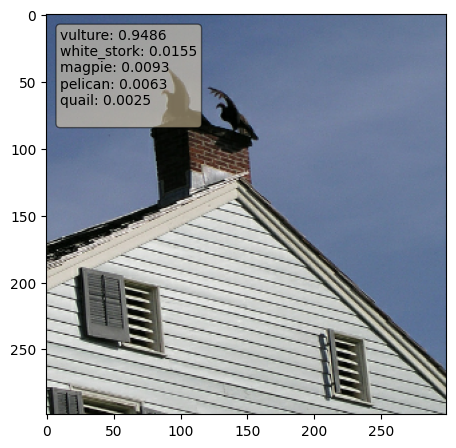

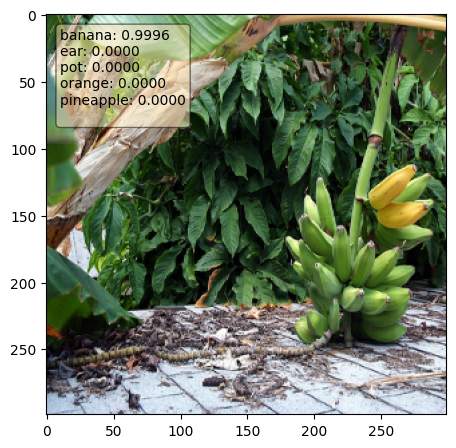

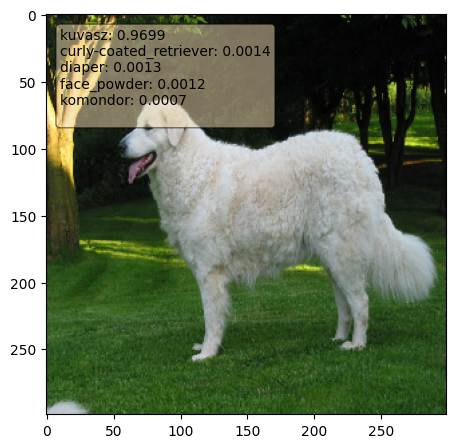

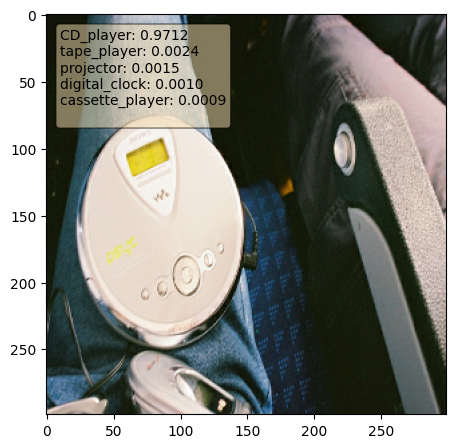

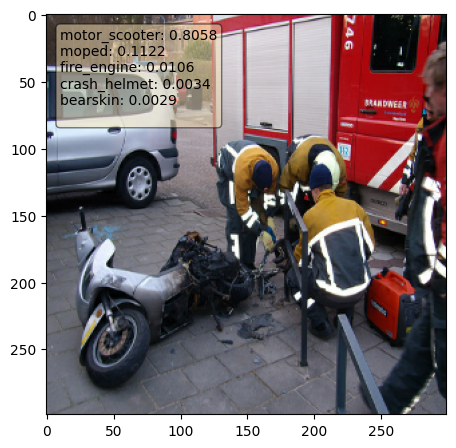

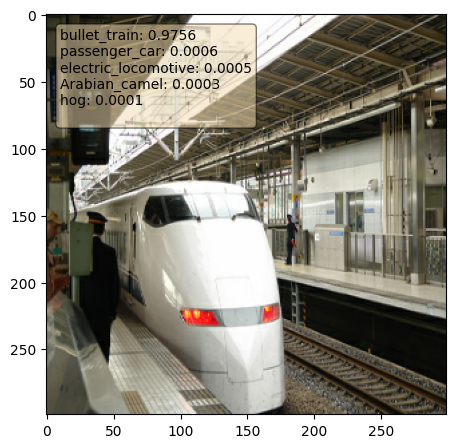

In [10]:
from tensorflow.keras.applications import inception_v3
import matplotlib.pyplot as plt

for images in dataset:
    predictions = inception_model.predict(images)
    decoded_predictions = inception_v3.decode_predictions(predictions)

    for i in range(len(decoded_predictions)):
        pred_str = ""
        for pred in decoded_predictions[i]:
            curr_pred = pred[1] + ": " + "{:1.4f}".format(pred[2])
            pred_str += curr_pred + "\n"

        fig = plt.figure(figsize=(4, 4), dpi=100)
        ax = fig.add_axes([0, 0, 1, 1])
        ax.imshow((images[i].numpy()* 127.5 + 127.5).astype("uint32"))
        props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
        ax.text(10, 10, pred_str, fontsize=10, verticalalignment='top', bbox=props)
        plt.show()           

Az említett, GAN teljesítménymérésére használatos módszerek az Inception Score (IS) és Fréchet Inception Distance (FID). Ezeket kívánom bemutatni az alábbi két alfejezetben.

### Inception Score (salimans2016improved, barratt2018note)

Az Inception Score technikát Salimans et al. az emberi tesztelés automatizálására vetette fel. A méréseik alapján a technika sok minta figyelembevételével igen jól közelíti az emberi tesztelők által mért eredményeket.
Alapjául az Inception model szolgál, amelyet az ImageNet dataseten tanítottak be. Minden egyes generált képet beadnak inputként a betanított Inception modellnek, hogy megkapják a conditional label eloszlást $p(y|x)$. Az olyan képeken, amelyeken jelentőségteljes objektumok figyelhetők meg, alacsony entrópiájú $p(y|x)$-el kell rendelkeznie. Vagyis a generált képen minél kevesebb objektumot kell felismernie a modellnek.
Továbbá az is lényeges szempont, hogy a generátor különféle képeket generálon, így a következőnek magas entrópiával kell rendelkeznie:
$$ \int p(y|x = G(z))dz $$

Az Inception Score tehát:

$$ \exp(\mathbb{E}_x KL(p(y|x)||p(y))) $$

Minél magasabb ez a szám, annál jobb a GAN teljesítménye. Természetesen az IS is kijátszható és hamis eredményeket is adhat. (Note on IS-ben van róla szó)

TODO: Írni még erről gondolatokat, pontosítani

[Az inception score kódja](https://github.com/openai/improved-gan/tree/master/inception_score)
TODO: Inception score implementálása Tensorflow 2-ben? Vagy az eredetivel kéne mérni? (Az még tf1-es)


### Fréchet Inception Distance (heusel2017gans)

Az Incepton Score kiegészítésére megjelent egy másik, széles körben elfogadott teljesítménymerő technika, a Fréchet Inception Distance (FID). Az IS nem vette figyelembe a tanítóminta statisztikáit, és ez egy igen nagy hátránya a technikának. Továbbá az IS feltételein is javítottak, hogy a mintákon megtalálható zajok is befolyásolják a végső eredményt.

TODO: Pontosítás!!!

Minél alacsonyabb az FID, annál jobb a modell teljesítménye az adott tanítómintán.

TODO: Összefoglaló táblázat, saját modellek eredményei, ábrák
